In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages
import numpy as np
import os
from tensorflow.keras.models import load_model # type: ignore
import tensorflow as tf
import pandas as pd
import json

# Local imports
from src.lstm_2.model_generation.helper_methods import generate_data, order_features_config
from src.data_processing.lstm_data_preprocessing import FeaturesConfig


2025-04-30 22:13:30.762229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746047610.904801  194743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746047610.944009  194743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746047611.233649  194743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746047611.233699  194743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746047611.233701  194743 computation_placer.cc:177] computation placer alr

In [3]:
# Custom loss function
def weighted_mse_large_moves(y_true, y_pred):
    diff = y_true - y_pred
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(diff))

# Empty dictionary to hold all models
models = {}

#model_names = ["lstm_3_32", "lstm_3_32_optimised", "lstm_2_128"]
model_names = ["lstm_3_32", "lstm_3_32_optimised"]


for model_name in model_names:
    model_folder = f"../model_generation/trained_models/{model_name}"
    model_name = f"model_{model_name}"
    with open(os.path.join(model_folder, "config.json"), 'r') as f:
        configs = json.load(f)
    features_config = configs["features_config"]
    time_bucket_folder = configs["time_bucket_folder"]
    test_size = configs["test_size"]
    model = load_model(os.path.join(model_folder, "model.keras"),
        custom_objects={'weighted_mse_large_moves': weighted_mse_large_moves})
    models[model_name] = {"model": model, "feature_config": features_config, "time_bucket_folder": time_bucket_folder, "test_size": test_size}

I0000 00:00:1746047616.117625  194743 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5006 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:08:00.0, compute capability: 8.9
/home/maked/CM3203-Project/CM3203-Venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 42 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
# 1. Get unique feature config / time bucket / test size combinations
unique_configs = set()

for model_info in models.values():
    config_key = (
        tuple(model_info["feature_config"].items()),
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )
    unique_configs.add(config_key)

# 2. Generate datasets once per unique config
datasets = {}

for config in unique_configs:
    features_config, time_bucket_folder, test_size = config
    
    # Rebuild dict to then use in order_features_config method to get ordered list of boolean values for features
    ordered_features_config = order_features_config(dict(features_config))

    # Create FeaturesConfig object
    features_config = FeaturesConfig(*ordered_features_config)

    # Generate / load data
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = generate_data(
        features_config=features_config,
        time_bucket_folder=time_bucket_folder,
        test_size=test_size
    )

    datasets[config] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_scaler": X_scaler,
        "y_scaler": y_scaler
    }


In [5]:
model_results = {}

for model_name, model_info in models.items():
    # Rebuild the config_key using the tuple of (key, value) pairs for feature_config
    config_key = (
        tuple(model_info["feature_config"].items()),  # <-- Ensure feature_config is a tuple of (key, value)
        model_info["time_bucket_folder"],
        model_info["test_size"]
    )

    # Fetch the corresponding data from datasets using the correct config_key
    data = datasets[config_key]

    X_test = data["X_test"]
    y_test = data["y_test"]
    model = model_info["model"]

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform to get real values
    y_pred_actual = data["y_scaler"].inverse_transform(y_pred)
    y_test_actual = data["y_scaler"].inverse_transform(y_test)

    # Save the predictions and actual values in model_results
    model_results[model_name] = {"pred": y_pred_actual, "real": y_test_actual}


I0000 00:00:1746047656.499922  194867 cuda_dnn.cc:529] Loaded cuDNN version 90300


523/523 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step
523/523 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step


In [6]:
import pickle

# Save model_results to a file
with open("top_model_results.pkl", "wb") as f:
    pickle.dump(model_results, f)

print("model_results saved successfully!")


model_results saved successfully!


In [7]:
# Load results
import pickle

with open("top_model_results.pkl", "rb") as f:
    model_results = pickle.load(f)

In [8]:
from metrics_methods import get_model_comparison, evaluate_large_move_model
comparison_results = get_model_comparison(model_results, metric_func=evaluate_large_move_model, threshold=1)

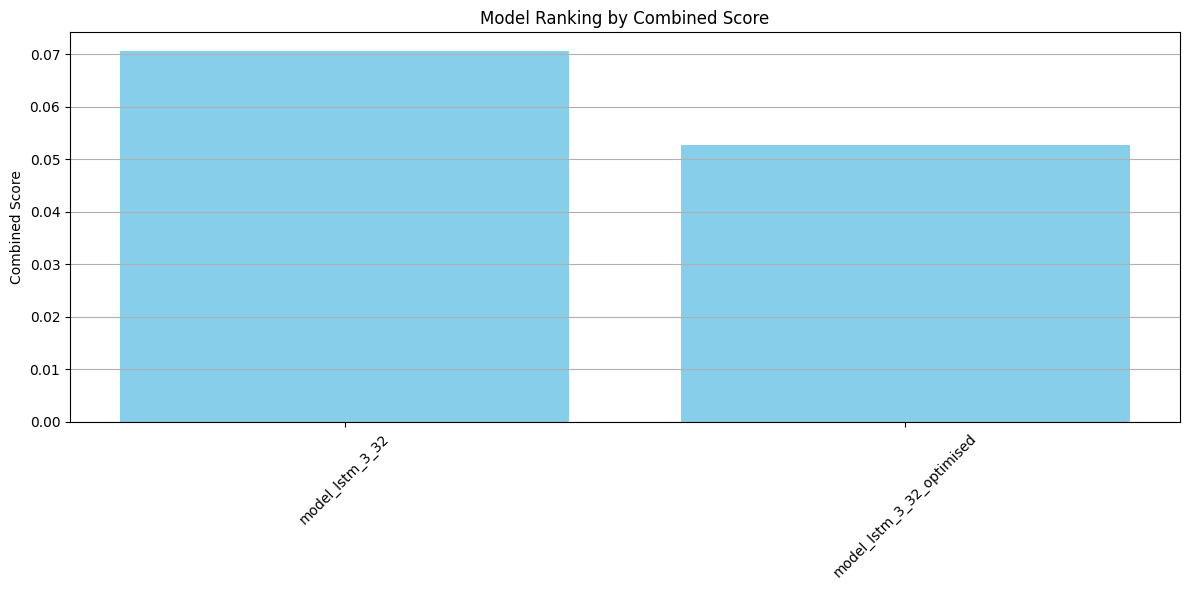

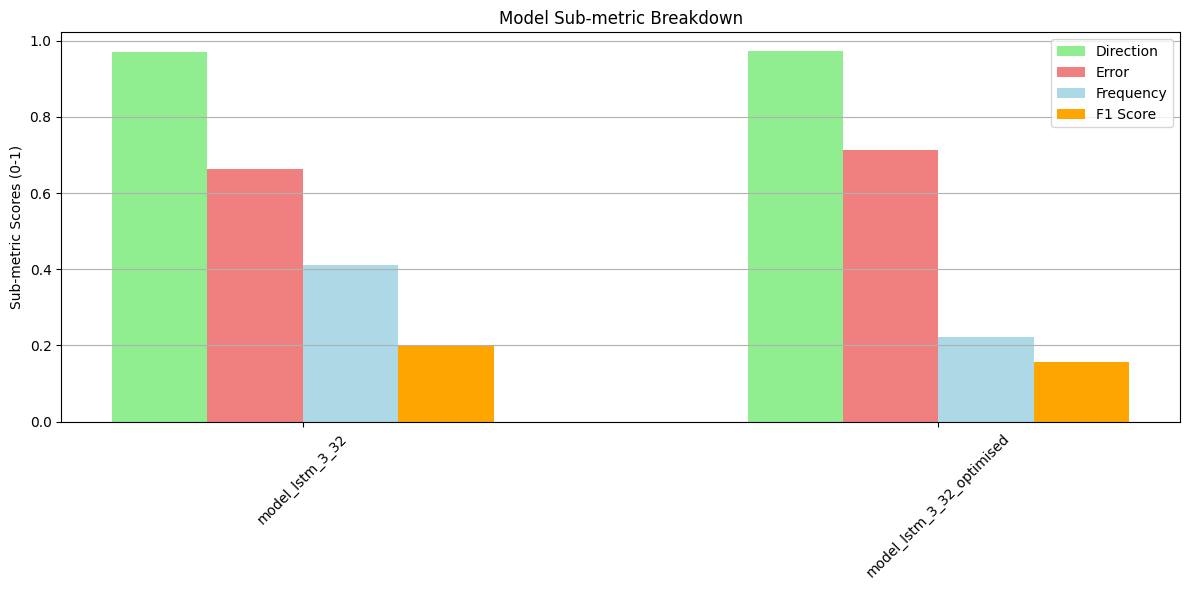

In [9]:
from visualisation_methods import plot_model_comparison
plot_model_comparison(comparison_results)

In [14]:
from src.lstm_2.model_generation.helper_methods import get_token_datasets, get_test_tokens_with_large_pred
from metrics_methods import test_trailing_strategy, test_base_strategy
from src.data_processing.loader import load_token_price_data

# Get token_dataset to use for calculating models profit on strategy
test_size = 0.2
time_bucket_folder = "time_bucket_1"
token_datasets = get_token_datasets(time_bucket_folder)
model_pnls_trailing_strat = {}
model_pnls_base_strat = {}

for model_name, results in model_results.items():
    predictions = results["pred"]
    test_tokens_pred = get_test_tokens_with_large_pred(token_datasets, test_size, predictions, min_abs_pred_size=1)
    # Load price data
    tokens_tx_data = {
        token: load_token_price_data(token, use_datetime=False)
        for token in test_tokens_pred.keys()
    }
    model_trailing_strategy_results = test_trailing_strategy(test_tokens_pred, tokens_tx_data, hold_time=120, min_time_between_buys=30, verbose=False)
    model_base_strategy_results = test_base_strategy(test_tokens_pred, tokens_tx_data, min_time_between_buys=30, verbose=False)


    model_pnls_trailing_strat[model_name] = model_trailing_strategy_results
    model_pnls_base_strat[model_name] = model_base_strategy_results

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import re

def plot_model_stats(results_dict):
    model_entries = []

    # Extract data
    model_names = [key for key in results_dict.keys()]
    total_profits = [float(value['total_profit']) for value in results_dict.values()]
    num_trades = [value['num_trades'] for value in results_dict.values()]
    num_wins = [value['num_wins'] for value in results_dict.values()]
    num_losses = [value['num_losses'] for value in results_dict.values()]

    x = np.arange(len(model_names))

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Total profit
    axs[0].bar(model_names, total_profits, color='green')
    axs[0].set_ylabel("Total Profit")
    axs[0].set_title("Model Performance: Total Profit")

    # Trades, wins, losses
    axs[1].bar(x - 0.2, num_wins, width=0.2, label='Wins', color='blue')
    axs[1].bar(x, num_losses, width=0.2, label='Losses', color='red')
    axs[1].bar(x + 0.2, num_trades, width=0.2, label='Trades', color='gray')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(model_names, rotation=45)
    axs[1].set_ylabel("Count")
    axs[1].set_title("Model Trade Breakdown")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


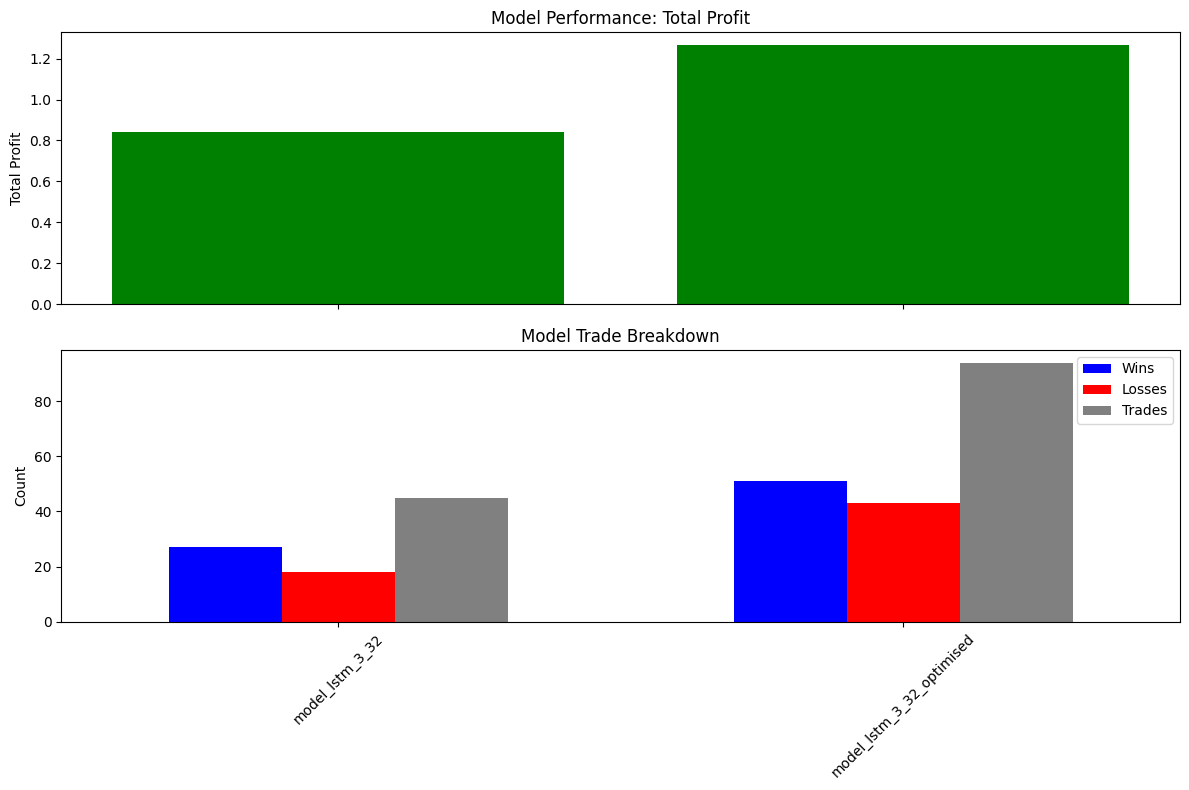

In [15]:
plot_model_stats(model_pnls_trailing_strat)

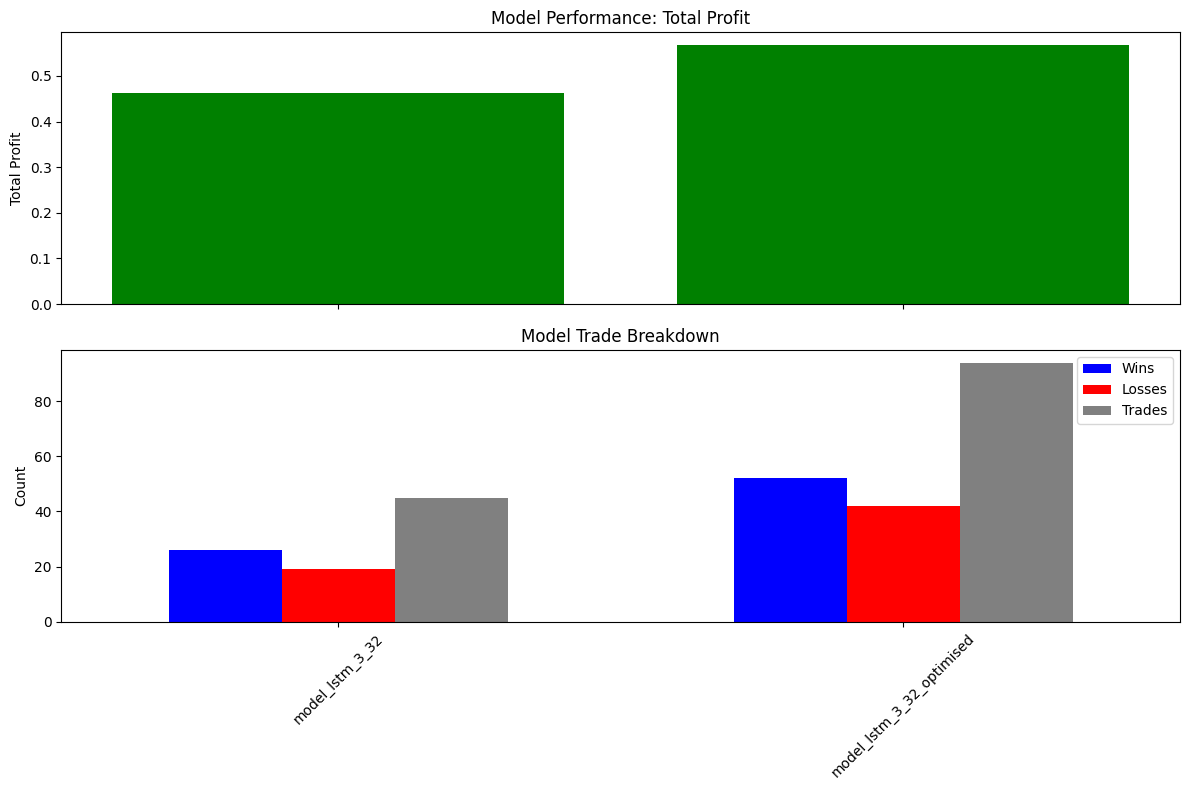

In [16]:
plot_model_stats(model_pnls_base_strat)